## Loads all the Chlorophyll Satellite data and saves it as a csv
Last edited by L. Gruenburg on  June 4, 2024

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import cartopy
import pandas as pn
from datetime import datetime
import geopandas as gpd
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import cartopy
import cartopy.crs as ccrs
import numpy as np
#import holoviews as hv
#from holoviews import opts
#from xmovie import Movie
#hv.extension('bokeh', 'matplotlib')
#hv.extension('matplotlib')

The surface chlorophyll data are from the TERRA/MODIS satellite mission details here https://oceancolor.gsfc.nasa.gov/about/missions/terra
You can download any updates to the data manually from this website

In [3]:
#a little test just to see what the data looks like
chlatest = xr.open_dataset('/Users/nyelab/Downloads/requested_files 2/TERRA_MODIS.20230801_20230831.L3m.MO.CHL.x_chlor_a.nc')

In [4]:
chlatest

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 312, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 41.98 41.94 41.9 41.85 ... 37.15 37.1 37.06 37.02
  * lon      (lon) float32 -77.98 -77.94 -77.9 -77.85 ... -65.1 -65.06 -65.02
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a  (lat, lon) float32 ...
    palette  (rgb, eightbitcolor) uint8 ...
Attributes: (12/61)
    product_name:                     TERRA_MODIS.20230801_20230831.L3m.MO.CH...
    instrument:                       MODIS
    title:                            MODIST Level-3 Equidistant Cylindrical ...
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Terra
    source:                           satellite observations from MODIS-Terra
    ...                               ...
    processing_level:                 L3 Mapped
    cdm_data_type:                    grid
    proj4_string:                     +proj=eqc +lat_ts=0 +lat_0=0 +x_0=0 +y_...
    data_bins:                        26811
    data_minimum:                     0.036623746
    data_maximum:                     83.61899

In [5]:
#These files live on the NYOS megafolder in the google drive in NYOS_megafolder/indicator.development/Indicators_MOST_RECENT_2023/Raw Data/Chlorophyll
import os
files = os.listdir('/Users/nyelab/Downloads/requested_files 2/')
files

['TERRA_MODIS.20170601_20170630.L3m.MO.CHL.x_chlor_a.nc',
 'TERRA_MODIS.20130801_20130831.L3m.MO.CHL.x_chlor_a.nc',
 'TERRA_MODIS.20181101_20181130.L3m.MO.CHL.x_chlor_a.nc',
 'TERRA_MODIS.20200901_20200930.L3m.MO.CHL.x_chlor_a.nc',
 'TERRA_MODIS.20051001_20051031.L3m.MO.CHL.x_chlor_a.nc',
 'TERRA_MODIS.20090301_20090331.L3m.MO.CHL.x_chlor_a.nc',
 'TERRA_MODIS.20140301_20140331.L3m.MO.CHL.x_chlor_a.nc',
 'TERRA_MODIS.20051101_20051130.L3m.MO.CHL.x_chlor_a.nc',
 'TERRA_MODIS.20200801_20200831.L3m.MO.CHL.x_chlor_a.nc',
 'TERRA_MODIS.20170201_20170228.L3m.MO.CHL.x_chlor_a.nc',
 'TERRA_MODIS.20181001_20181031.L3m.MO.CHL.x_chlor_a.nc',
 'TERRA_MODIS.20130901_20130930.L3m.MO.CHL.x_chlor_a.nc',
 'TERRA_MODIS.20170701_20170731.L3m.MO.CHL.x_chlor_a.nc',
 'TERRA_MODIS.20110501_20110531.L3m.MO.CHL.x_chlor_a.nc',
 'TERRA_MODIS.20220401_20220430.L3m.MO.CHL.x_chlor_a.nc',
 'TERRA_MODIS.20120101_20120131.L3m.MO.CHL.x_chlor_a.nc',
 'TERRA_MODIS.20210101_20210131.L3m.MO.CHL.x_chlor_a.nc',
 'TERRA_MODIS.

In [6]:
# Merge the data from all teh separate files together
chla_data = np.empty([120,312, 283])
chla_data[:,:,:] = np.nan
chla_month = np.empty(283)
chla_month[:] = np.nan
chla_year = np.empty(283)
chla_year[:] = np.nan
chla_date = 'start'

for i in range(283):
    file_name = files[i]
    chl = xr.open_dataset('/Users/nyelab/Downloads/requested_files 2/' + file_name)
    date = pn.to_datetime((getattr(chl,'time_coverage_end')))
    month = pn.to_datetime((getattr(chl,'time_coverage_end'))).month
    year = pn.to_datetime((getattr(chl,'time_coverage_end'))).year
    chla_data[:,:,i] = chl.chlor_a
    chla_month[i] = month
    chla_year[i] = year
    chla_date = np.append(chla_date, str(month) + '-' + str(year))

In [7]:
#Double checking the date variable
chla_date = chla_date[1:]
chla_t = pn.to_datetime(chla_date)
len(chla_date)

/var/folders/ys/jb4xnd9x6vb6xqb52tk47scr0000gp/T/ipykernel_7422/1297371461.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chla_t = pn.to_datetime(chla_date)


283

In [69]:

#i=0
#m = np.sort(pn.to_datetime(chla_date))[i]
#m
#index = np.where(chla_t == m)
#index[0][0]

112

In [8]:
# The data is not in chronologicl order, this step reorders the data
chla_in_order = np.empty([120,312, 283])
chla_in_order[:,:,:] = np.nan

for i in range(283):
    m = np.sort(pn.to_datetime(chla_date))[i]
    index = np.where(chla_t == m)
    chla_in_order[:,:,i] = chla_data[:,:,index[0][0]]
    

/var/folders/ys/jb4xnd9x6vb6xqb52tk47scr0000gp/T/ipykernel_7422/1194228015.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  m = np.sort(pn.to_datetime(chla_date))[i]
/var/folders/ys/jb4xnd9x6vb6xqb52tk47scr0000gp/T/ipykernel_7422/1194228015.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  m = np.sort(pn.to_datetime(chla_date))[i]
/var/folders/ys/jb4xnd9x6vb6xqb52tk47scr0000gp/T/ipykernel_7422/1194228015.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  m = np.sort(pn.to_datetime(chla_date))[i]
/var/folders/ys/jb4xnd9x6vb6xqb52tk47scr0000gp/T/ipykernel_7422/119422801

In [9]:
# Create a dataset for the chlorohpyll data
CH = xr.Dataset(data_vars ={'chla': (['lat','lon','time'], chla_in_order)},
               coords = {'lat': chl.lat,
                        'lon': chl.lon,
                        'time': np.sort(pn.to_datetime(chla_date))})

/var/folders/ys/jb4xnd9x6vb6xqb52tk47scr0000gp/T/ipykernel_7422/3901151292.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  'time': np.sort(pn.to_datetime(chla_date))})


/var/folders/ys/jb4xnd9x6vb6xqb52tk47scr0000gp/T/ipykernel_7422/3326903975.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(CH.time, np.nanmean(np.nanmean(CH.chla, 0),0))


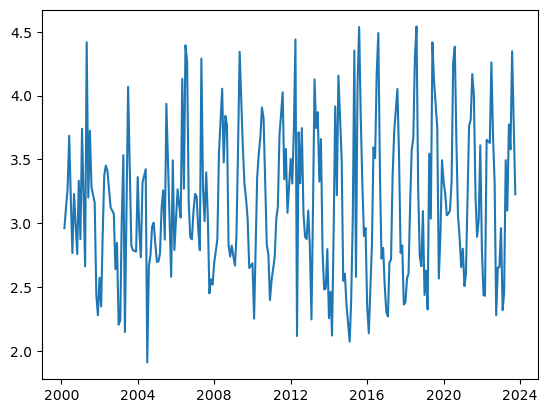

In [10]:
# make a plot to look at it
plt.plot(CH.time, np.nanmean(np.nanmean(CH.chla, 0),0))

In [21]:
# Load NYB shapefile
NYB = gpd.read_file('/Users/nyelab/Desktop/NYB Indicators/Datasets/Shapefiles/PlanningArea_NYocean_NYSDOS.shp')
# Alter the projection to WGS84 see https://epsg.io/4326
NYB = NYB.to_crs(epsg=4326)
# Extract the polygon
nyb_shape = NYB.geometry[0]

In [26]:
#empty matrix for the function below
NYB_new = np.empty([120,312,283])
NYB_new[:,:,:]=np.nan


In [22]:
#function to only extract data in our EPU
def inEPU(empty_matrix, shape, lon_mat_name, lat_mat_name,variable_matrix):
    for i in range(120):
        for j in range(312):
            if Point(lon_mat_name[j], lat_mat_name[i]).within(shape) == True:
                empty_matrix[i,j,:] = variable_matrix[i,j,:]
    return empty_matrix

In [27]:
#keeping only surface chla data for the nyb
nyb_chla = inEPU(NYB_new, nyb_shape, CH.lon, CH.lat, CH.chla)

In [29]:
# spatially averaged timeseries of the nyb surfcae chlorophyll
chla_ts = np.nanmean(np.nanmean(nyb_chla,0),0)

/var/folders/ys/jb4xnd9x6vb6xqb52tk47scr0000gp/T/ipykernel_7422/237239665.py:2: RuntimeWarning: Mean of empty slice
  chla_ts = np.nanmean(np.nanmean(nyb_chla,0),0)


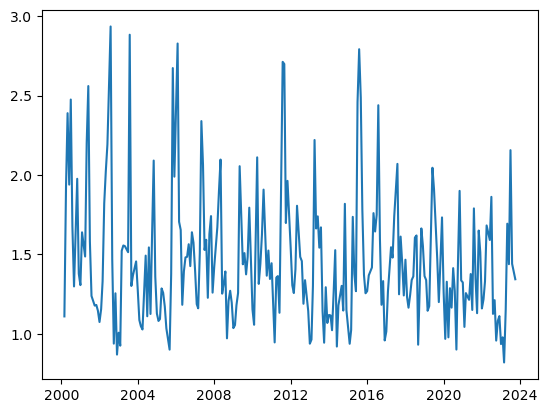

In [30]:
plt.plot(CH.time, chla_ts)

In [31]:
#Create the dataframe of this nyb spatially averaged ts for export to .csv
chlorophyll = pn.DataFrame({'date': CH.time,
             'chla': chla_ts})

In [96]:
#Export to .csv for final plotting
chlorophyll.to_csv('/Users/nyelab/Desktop/NYB Indicators/NYB_Indicators_Calculations/Final_Timeseries_Figures/Timeseries_Files_2023/chla_2023.csv')

## Everything below this is not necessary for the indicators

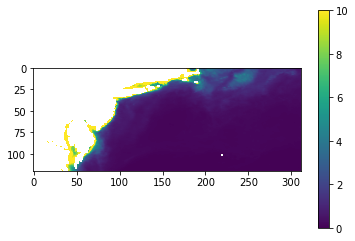

In [11]:
%matplotlib inline
plt.imshow(chlatest.chlor_a, vmin = 0, vmax = 10)
plt.colorbar()

In [7]:
#chla = xr.open_dataset('/Users/nyelab/Downloads/CCI_ALL-v5.0-MONTHLY.nc')
chla = xr.open_dataset('/Users/nyelab/Downloads/pmlEsaCCI50OceanColorMonthly_82cc_542d_f222.nc')

In [23]:
chla

<xarray.Dataset>
Dimensions:    (latitude: 409, longitude: 481, time: 292)
Coordinates:
  * time       (time) datetime64[ns] 1997-09-04 1997-10-01 ... 2021-12-01
  * latitude   (latitude) float64 44.98 44.94 44.9 44.85 ... 28.06 28.02 27.98
  * longitude  (longitude) float64 -84.98 -84.94 -84.9 ... -65.06 -65.02 -64.98
Data variables:
    chlor_a    (time, latitude, longitude) float32 ...
Attributes: (12/52)
    cdm_data_type:                     Grid
    comment:                           See summary attribute
    Conventions:                       CF-1.7, COARDS, ACDD-1.3
    creation_date:                     Mon Jan 31 16:52:22 2022
    creator_email:                     help@esa-oceancolour-cci.org
    creator_name:                      Plymouth Marine Laboratory
    ...                                ...
    time_coverage_end:                 2021-12-01T00:00:00Z
    time_coverage_resolution:          P1M
    time_coverage_start:               1997-09-04T00:00:00Z
    title:                             ESA CCI Ocean Colour Product (CCI ALL-...
    tracking_id:                       dc02d30c-8076-46ce-b8b0-b089050b1039
    Westernmost_Easting:               -84.97916666666667

In [9]:
# Load NYB shapefile
NYB = gpd.read_file('/Users/nyelab/Desktop/NYB Indicators/Datasets/Shapefiles/PlanningArea_NYocean_NYSDOS.shp')
# Alter the projection to WGS84 see https://epsg.io/4326
NYB = NYB.to_crs(epsg=4326)
# Extract the polygon
nyb_shape = NYB.geometry[0]

In [5]:
# Load MAB and GoM shapefiles (already in WGS84).
# Note that this also contains shapefiles for the Scotia Shelf at index 2 and the Grand Banks at index 3.
EPU = gpd.read_file('/Users/nyelab/Desktop/NYB Indicators/Datasets/Shapefiles/EPU_NOESTUARIES.shp')
mab_shape = EPU.geometry[0]
gom_shape = EPU.geometry[1]

In [6]:
NYB

,ID,area_m,dummy,Shape_Leng,Shape_Area,Area_SqMi,geometry
0,0.0,43471.799751,0,910713.7766,4.347178e+10,16784.548944,"POLYGON ((-71.66879 41.05893, -71.64509 40.949..."


In [11]:
(lon, lat) = np.meshgrid(chla.longitude,chla.latitude)

In [12]:
NYB = np.empty([409,481])
NYB[:,:]=np.nan
EPU = np.empty([409,481])
EPU[:,:]=np.nan

In [13]:
def inEPU(empty_matrix, shape, lon_mat_name, lat_mat_name,value):
    for i in range(409):
        for j in range(481):
            if Point(lon_mat_name[i,j], lat_mat_name[i,j]).within(shape) == True:
                empty_matrix[i,j] = value
    return empty_matrix

In [15]:
NYB = inEPU(NYB,nyb_shape, lon,lat,1)
#EPU = inEPU(EPU,mab_shape,lon,lat,1)
#EPU = inEPU(EPU,gom_shape,lon,lat,2)

In [18]:
NYB = xr.DataArray(data = NYB, dims={'latitude': 409, 'longitude': 481}, coords = {'latitude':chla.latitude,'longitude': chla.longitude})
nyb = NYB.to_dataset(name='nyb')
#EPU = xr.DataArray(data = EPU, dims={'lat': 409, 'lon': 481}, coords = {'lat':chla.lat,'lon': chla.lon})
#epu = EPU.to_dataset(name='epu')

In [12]:
chla = xr.merge([chla, nyb, epu])

In [26]:
dates = pn.DatetimeIndex(chla.time.values)
unique_years = np.unique(dates.year)

In [20]:
nyb

<xarray.Dataset>
Dimensions:    (latitude: 409, longitude: 481)
Coordinates:
  * latitude   (latitude) float64 44.98 44.94 44.9 44.85 ... 28.06 28.02 27.98
  * longitude  (longitude) float64 -84.98 -84.94 -84.9 ... -65.06 -65.02 -64.98
Data variables:
    nyb        (latitude, longitude) float64 nan nan nan nan ... nan nan nan nan

In [17]:
chlaMAB = np.empty([280,409,481])
chlaGOM = np.empty([280,409,481])

for j in range(409):
    for k in range(481):
        if chla.epu[j,k] == 1:
            chlaMAB[:,j,k] = chla.chlor_a[:,j,k]
            chlaGOM[:,j,k] = np.nan
        if chla.epu[j,k] == 2:
            chlaMAB[:,j,k] = np.nan
            chlaGOM[:,j,k] = chla.chlor_a[:,j,k]
        if chla.epu[j,k] != 1 and chla.epu[j,k] != 2:
            chlaMAB[:,j,k] = np.nan
            chlaGOM[:,j,k] = np.nan

In [24]:
chlaNYB = np.empty([292,409,481])
for j in range(409):
    for k in range(481):
        if nyb.nyb[j,k] == 1:
            chlaNYB[:,j,k] = chla.chlor_a[:,j,k]
        else:
            chlaNYB[:,j,k] = np.nan


In [27]:
# Creates matricies of monthoy means the data by year
#monthly_gom = np.empty([len(unique_years),12])
#monthly_mab = np.empty([len(unique_years),12])
monthly_nyb = np.empty([len(unique_years),12])
k=0
for i in (unique_years):
    #year_pickedMAB = np.nanmean(np.nanmean(chlaMAB[dates.year == i,:,:],1),1)
    #year_pickedGOM = np.nanmean(np.nanmean(chlaGOM[dates.year == i,:,:],1),1)
    year_pickedNYB = np.nanmean(np.nanmean(chlaNYB[dates.year == i,:,:],1),1)
    months_picked = dates[dates.year == i].month
    for j in range(len(months_picked)):
        #monthly_gom[k,months_picked[j]-1] = year_pickedGOM[j]
        #monthly_mab[k,months_picked[j]-1] = year_pickedMAB[j]
        monthly_nyb[k,months_picked[j]-1] = year_pickedNYB[j]
    k = k+1

<ipython-input-27-a5e74231f909>:9: RuntimeWarning: Mean of empty slice
  year_pickedNYB = np.nanmean(np.nanmean(chlaNYB[dates.year == i,:,:],1),1)
<ipython-input-27-a5e74231f909>:9: RuntimeWarning: Mean of empty slice
  year_pickedNYB = np.nanmean(np.nanmean(chlaNYB[dates.year == i,:,:],1),1)
<ipython-input-27-a5e74231f909>:9: RuntimeWarning: Mean of empty slice
  year_pickedNYB = np.nanmean(np.nanmean(chlaNYB[dates.year == i,:,:],1),1)
<ipython-input-27-a5e74231f909>:9: RuntimeWarning: Mean of empty slice
  year_pickedNYB = np.nanmean(np.nanmean(chlaNYB[dates.year == i,:,:],1),1)
<ipython-input-27-a5e74231f909>:9: RuntimeWarning: Mean of empty slice
  year_pickedNYB = np.nanmean(np.nanmean(chlaNYB[dates.year == i,:,:],1),1)
<ipython-input-27-a5e74231f909>:9: RuntimeWarning: Mean of empty slice
  year_pickedNYB = np.nanmean(np.nanmean(chlaNYB[dates.year == i,:,:],1),1)
<ipython-input-27-a5e74231f909>:9: RuntimeWarning: Mean of empty slice
  year_pickedNYB = np.nanmean(np.nanmean(chlaNY

In [28]:
len(monthly_nyb)
len(unique_years)
d = {'jan': monthly_nyb[:,0], 'feb': monthly_nyb[:,1], 'mar': monthly_nyb[:,2],
    'apr': monthly_nyb[:,3], 'may': monthly_nyb[:,4], 'jun': monthly_nyb[:,5],
    'jul': monthly_nyb[:,6], 'aug': monthly_nyb[:,7], 'sep': monthly_nyb[:,8],
    'oct': monthly_nyb[:,9], 'nov': monthly_nyb[:,10], 'dec': monthly_nyb[:,11]}
chla_nyb = pn.DataFrame(data = d, index = unique_years)
chla_nyb.to_csv('/Users/nyelab/Desktop/NYB Indicators/FInal_Timeseries/chla_nyb_12_14_2022.csv')


In [31]:
chla_nyb

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
1997,0.000000,6.945566e-310,0.000000,6.945566e-310,6.945566e-310,6.945504e-310,0.000000,3.952525e-323,0.938761,0.917878,1.043779,1.110976
1998,1.176134,1.103954e+00,1.212037,1.103607e+00,1.011803e+00,7.742477e-01,0.881135,6.945284e-01,0.818892,0.983048,1.570839,1.546005
1999,1.197840,1.144475e+00,1.385016,1.174523e+00,1.211397e+00,7.568808e-01,0.674217,8.370638e-01,0.984322,1.120421,1.530949,1.103108
2000,0.961602,8.774532e-01,0.995816,1.378299e+00,1.295714e+00,1.135891e+00,1.378462,1.120973e+00,1.017472,1.095093,1.254500,1.594830
2001,1.308013,1.319528e+00,1.265856,1.389444e+00,1.077947e+00,1.295671e+00,1.147938,8.730565e-01,0.764000,0.989216,1.056674,1.289090
2002,1.223508,1.087086e+00,1.198268,1.163225e+00,1.245685e+00,1.315188e+00,1.594023,1.503476e+00,0.922599,0.898632,1.196263,0.968906
2003,1.093468,9.363573e-01,1.527698,1.293693e+00,9.870555e-01,9.193991e-01,0.764717,1.433714e+00,0.890208,0.942229,1.269093,1.253734
2004,1.280827,9.761722e-01,1.017109,1.000448e+00,9.211315e-01,7.475120e-01,0.665116,8.499575e-01,0.818637,1.152433,1.587037,1.139713
2005,1.120211,9.607406e-01,1.027032,1.125025e+00,8.992166e-01,7.493014e-01,0.722554,6.997196e-01,0.721364,1.228895,2.139678,1.775442
2006,1.675205,1.278822e+00,1.565744,1.172443e+00,8.439139e-01,9.429207e-01,1.006983,1.155788e+00,0.935489,1.105275,1.460352,1.194962


In [30]:
chla_nyb.to_csv('/Users/nyelab/Desktop/NYB Indicators/FInal_Timeseries/chla_nyb_12_14_2022.csv')

In [23]:
np.shape(monthly_nyb)

(24, 12)

Text(0, 0.25, 'Chla ($\\mathregular{mg m^{-3}}$)')

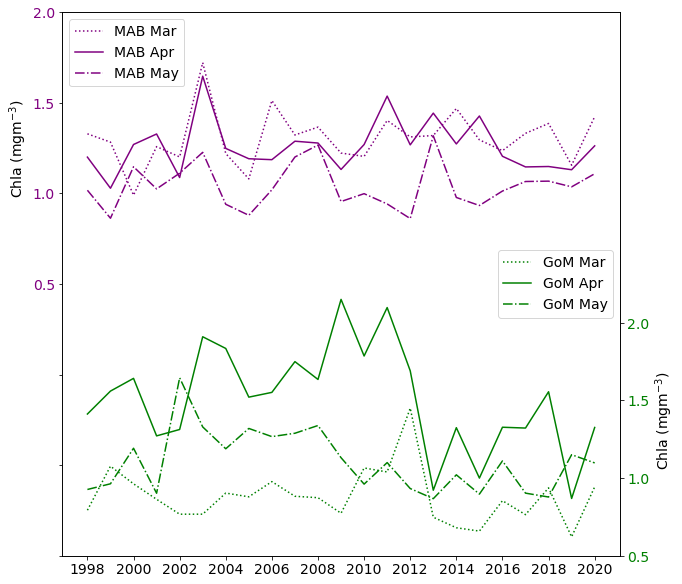

In [21]:
fig, ax = plt.subplots(figsize = [10,10])

#ax.plot(unique_years, monthly_mab[:,1], 'purple', linestyle = (0,(3,5,1,5)))
ax.plot(unique_years[1:], monthly_mab[1:,2], 'purple', linestyle = ':', label = "MAB Mar")
ax.plot(unique_years[1:], monthly_mab[1:,3], 'purple', linestyle = '-', label = 'MAB Apr')
ax.plot(unique_years[1:], monthly_mab[1:,4], 'purple', linestyle = '-.', label = 'MAB May')

ax.set_yticks(np.arange(-1,2.5,0.5))
ax.set_yticklabels(['','','',0.5,1.0,1.5,2.0], fontsize = 14, color = 'purple')
ax.set_ylabel('Chla ($\mathregular{mg m^{-3}}$)', fontsize = 14, y=0.75)

ax2 = plt.twinx(ax)

ax2.plot(unique_years[1:], monthly_gom[1:,2], 'green', linestyle = ':', label = 'GoM Mar')
ax2.plot(unique_years[1:], monthly_gom[1:,3], 'green', linestyle = '-', label = 'GoM Apr')
ax2.plot(unique_years[1:], monthly_gom[1:,4], 'green', linestyle = '-.', label = 'GoM May')

ax2.set_ylim([0.5,4])
ax2.set_yticks([0.5, 1.0, 1.5, 2.0])
ax2.set_yticklabels([0.5, 1.0, 1.5, 2.0], fontsize = 14, color = 'green')

ax.legend(fontsize = 14, loc = 'upper left')
ax2.legend(fontsize = 14, loc = 'center right')
ax.set_xticks(np.arange(1998,2022,2))
ax.set_xticklabels(np.arange(1998,2022,2), fontsize = 14)
ax2.set_ylabel('Chla ($\mathregular{mg m^{-3}}$)', fontsize = 14, y=0.25)


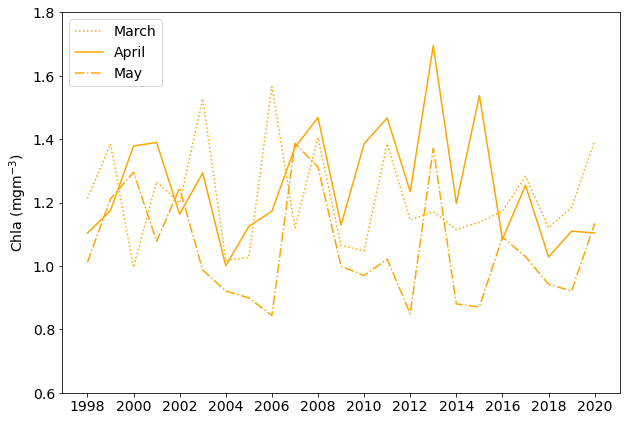

In [22]:
fig, ax = plt.subplots(figsize = [10,7])

#ax.plot(unique_years, monthly_mab[:,1], 'purple', linestyle = (0,(3,5,1,5)))
ax.plot(unique_years[1:], monthly_nyb[1:,2], 'orange', linestyle = ':', label = "March")
ax.plot(unique_years[1:], monthly_nyb[1:,3], 'orange', linestyle = '-', label = 'April')
ax.plot(unique_years[1:], monthly_nyb[1:,4], 'orange', linestyle = '-.', label = 'May')

ax.set_yticks(np.arange(0.6,2,0.2))
ax.tick_params(labelsize = 14)
#ax.set_yticklabels(['','','',0.5,1.0,1.5,2.0], fontsize = 14, color = 'purple')
ax.set_ylabel('Chla ($\mathregular{mg m^{-3}}$)', fontsize = 14, y=0.5)
ax.set_xticks(np.arange(1998,2022,2))
ax.set_xticklabels(np.arange(1998,2022,2), fontsize = 14)
ax.legend(fontsize = 14, loc = 'upper left')

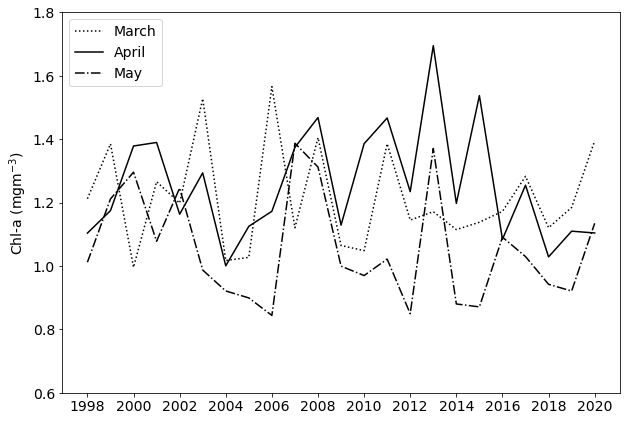

In [23]:
fig, ax = plt.subplots(figsize = [10,7])

#ax.plot(unique_years, monthly_mab[:,1], 'purple', linestyle = (0,(3,5,1,5)))
ax.plot(unique_years[1:], monthly_nyb[1:,2], 'k', linestyle = ':', label = "March")
ax.plot(unique_years[1:], monthly_nyb[1:,3], 'k', linestyle = '-', label = 'April')
ax.plot(unique_years[1:], monthly_nyb[1:,4], 'k', linestyle = '-.', label = 'May')

ax.set_yticks(np.arange(0.6,2,0.2))
ax.tick_params(labelsize = 14)
#ax.set_yticklabels(['','','',0.5,1.0,1.5,2.0], fontsize = 14, color = 'purple')
ax.set_ylabel('Chl-a ($\mathregular{mg m^{-3}}$)', fontsize = 14, y=0.5)
ax.set_xticks(np.arange(1998,2022,2))
ax.set_xticklabels(np.arange(1998,2022,2), fontsize = 14)
ax.legend(fontsize = 14, loc = 'upper left')

In [24]:
# plot the actual years
mab_ts = monthly_mab[0,:]
nyb_ts = monthly_nyb[0,:]
gom_ts = monthly_gom[0,:]
for i in range(1,24):
    mab_ts = np.append(mab_ts,monthly_mab[i,:])
    nyb_ts = np.append(nyb_ts,monthly_nyb[i,:])
    gom_ts = np.append(gom_ts,monthly_gom[i,:])

In [25]:
nyb_ts= nyb_ts[8:]
mab_ts = mab_ts[8:]
gom_ts = gom_ts[8:]

[]

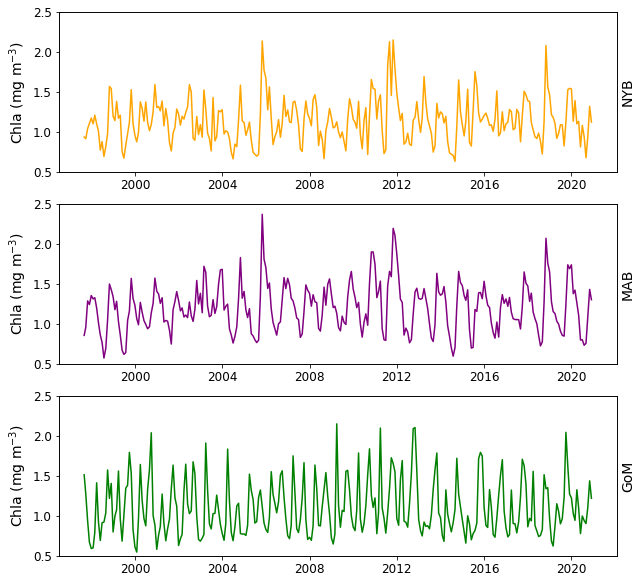

In [26]:
fig2, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (10,10))

ax[0].plot(chla.time,nyb_ts,'orange')
ax[0].set_ylim([0.5,2.5])
ax[0].tick_params(labelsize = 12)
ax[0].set_ylabel('Chla (mg $\mathregular{m^{-3}}$)', fontsize = 14, y=0.5)
ax2 = plt.twinx(ax[0])
ax2.set_ylabel('NYB', fontsize = 14)
ax2.set_yticks([])

ax[1].plot(chla.time,mab_ts,'purple')
ax[1].set_ylim([0.5,2.5])
ax[1].tick_params(labelsize = 12)
ax[1].set_ylabel('Chla (mg $\mathregular{m^{-3}}$)', fontsize = 14, y=0.5)
ax3 = plt.twinx(ax[1])
ax3.set_ylabel('MAB', fontsize = 14)
ax3.set_yticks([])

ax[2].plot(chla.time,gom_ts,'green')
ax[2].set_ylim([0.5,2.5])
ax[2].tick_params(labelsize = 12)
ax[2].set_ylabel('Chla (mg $\mathregular{m^{-3}}$)', fontsize = 14, y=0.5)
ax4 = plt.twinx(ax[2])
ax4.set_ylabel('GoM', fontsize = 14)
ax4.set_yticks([])

In [27]:
YR = pn.DatetimeIndex(chla.time.values).year
#MO = pn.DatetimeIndex(chla.time.values).month

In [28]:
MO = pn.to_datetime(chla.time.values, format='%m').month_name().str.slice(stop=3)
MO

Index(['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       ...
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
      dtype='object', length=280)

Text(0.5, 1.0, 'Satellite Chla, Jul 1998')

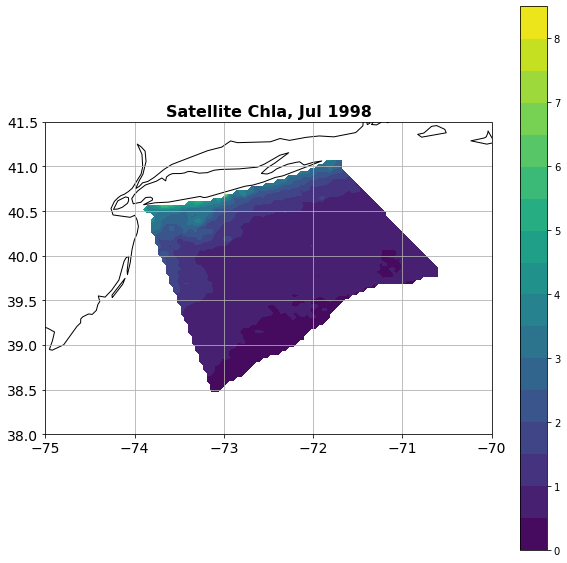

In [40]:
i=10
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
extent = [285,290,38.5,41.5]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')
C=plt.contourf(chla.lon,chla.lat,chlaNYB[4,:,:],levels = np.arange(0,9,0.5))
#C2 = ax.contour(X, Y, Z,levels=np.arange(0,25,2.5),colors = 'k',vmax = 80)
#ax.plot(360-X, Y, "ok", label="station")
#plt.plot(x, y, "ok", label="input point")
#plt.title('SON CTD 2019 MLD (temp)')
plt.colorbar(C)
#plt.clabel(C2)
ax.set_xticks(np.arange(-75,-69,1), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(38,42,0.5), crs=ccrs.PlateCarree())
ax.tick_params(labelsize=14)
#plt.contourf(chla.lon,chla.lat,chlaNYB[0,:,:])
plt.title('Satellite Chla, ' + MO[i] + ' ' + str(YR[i]), fontsize = 16, fontweight = 'bold')

In [47]:
chla.lon


<xarray.DataArray 'lon' (lon: 481)>
array([-84.979167, -84.9375  , -84.895833, ..., -65.0625  , -65.020833,
       -64.979167])
Coordinates:
  * lon      (lon) float64 -84.98 -84.94 -84.9 -84.85 ... -65.06 -65.02 -64.98
Attributes:
    units:                degrees_east
    long_name:            longitude
    standard_name:        longitude
    valid_min:            -179.97916666666666
    valid_max:            179.97916666666663
    axis:                 X
    _ChunkSizes:          270
    _CoordinateAxisType:  Lon

In [30]:
#chlaNYB = chlaNYB.transpose([0,2,1])

Text(0.5, 1.0, 'Satellite Chla, Jul 1998')

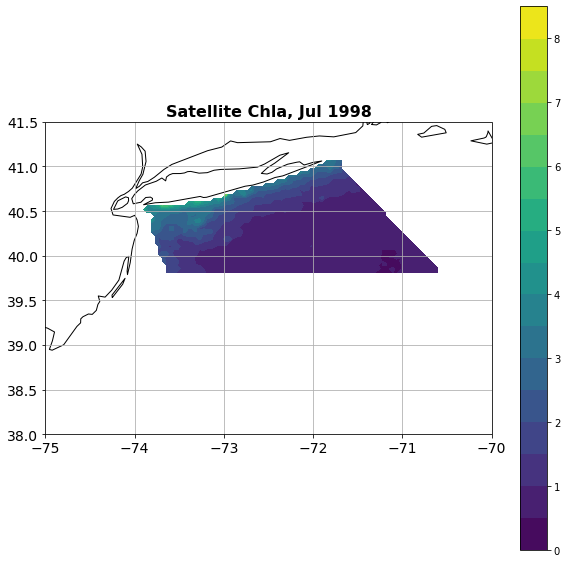

In [46]:
i=10
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
extent = [285,290,38.5,41.5]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')
C=plt.contourf(chla.lon,chla.lat[:125],chlaNYB[4,:125,:],levels = np.arange(0,9,0.5))
#C2 = ax.contour(X, Y, Z,levels=np.arange(0,25,2.5),colors = 'k',vmax = 80)
#ax.plot(360-X, Y, "ok", label="station")
#plt.plot(x, y, "ok", label="input point")
#plt.title('SON CTD 2019 MLD (temp)')
plt.colorbar(C)
#plt.clabel(C2)
ax.set_xticks(np.arange(-75,-69,1), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(38,42,0.5), crs=ccrs.PlateCarree())
ax.tick_params(labelsize=14)
#plt.contourf(chla.lon,chla.lat,chlaNYB[0,:,:])
plt.title('Satellite Chla, ' + MO[i] + ' ' + str(YR[i]), fontsize = 16, fontweight = 'bold')

In [168]:
chla_NYB = xr.DataArray(data = chlaNYB, coords = {'time':chla.time, 'lon':chla.lon, 'lat':chla.lat}, dims = ['time','lon','lat'])

In [161]:
#Chla_NYB = chla_NYB.transpose('time','lon','lat', transpose_coords = True)

In [80]:
def custom_plotfunc(chlaNYB, fig, tt, framedim="time"):
    
    ax = fig.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
    extent = [285,290,38.5,41.5]
    ax.set_extent(extent)
    ax.gridlines()
    ax.coastlines(resolution='50m')
    C=plt.contourf(chlaNYB.lon,chlaNYB.lat,chlaNYB[tt,:,:],levels = np.arange(0,9,0.5))
    #C2 = ax.contour(X, Y, Z,levels=np.arange(0,25,2.5),colors = 'k',vmax = 80)
    #ax.plot(360-X, Y, "ok", label="station")
    #plt.plot(x, y, "ok", label="input point")
    #plt.title('SON CTD 2019 MLD (temp)')
    plt.colorbar(C)
    #plt.clabel(C2)
    ax.set_xticks(np.arange(-75,-69,1), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(38,42,0.5), crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=14)
    #plt.contourf(chla.lon,chla.lat,chlaNYB[0,:,:])
    plt.title('Satellite Chla, ' + MO[tt] + ' ' + str(YR[tt]), fontsize = 16, fontweight = 'bold')
    
    #fig.colorbar(scat, label='Depth [m]', shrink=0.8, ticks=np.arange(0, 6000, 1000))
    
    fig.subplots_adjust(top=0.8)
    
    return ax, C



In [83]:
mov = Movie(chlaNYB)

/Users/nyelab/miniconda3/lib/python3.8/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/Users/nyelab/miniconda3/lib/python3.8/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


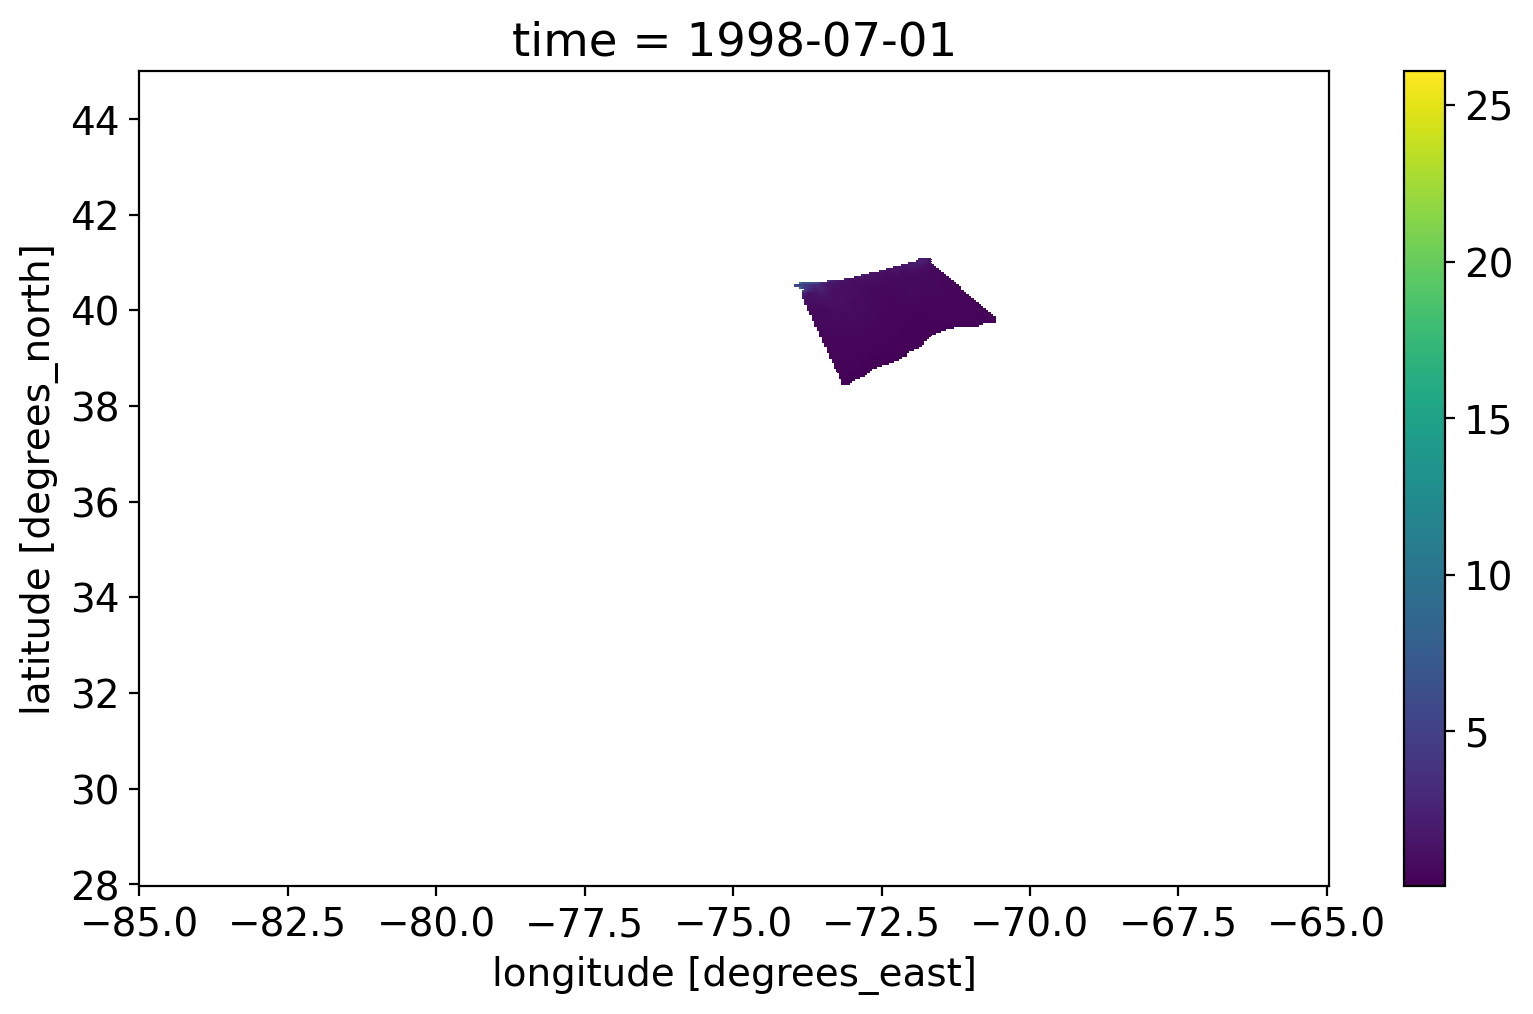

In [84]:
mov.preview(10)

In [101]:
ds = hv.Dataset((chla.lon, chla.lat, chla.time, chlaNYB),
                ['lon', 'lat', 'time'], 'Chlorophyll a')
ds

:Dataset   [lon,lat,time]   (Chlorophyll a)

In [96]:
ds = ds.clone(datatype=['xarray']).data

In [100]:
opts.defaults(
    opts.GridSpace(shared_xaxis=True, shared_yaxis=True),
    opts.Image(cmap='viridis', width=400, height=400),
    opts.Labels(text_color='white', text_font_size='8pt', text_align='left', text_baseline='bottom'),
    opts.Path(color='white'),
    opts.Spread(width=600),
    opts.Overlay(show_legend=False))


In [103]:
ds.to(hv.Image, ['lon', 'lat']).hist()

KeyboardInterrupt: 

In [109]:
np.shape(chlaNYB)

(280, 409, 481)

In [104]:
from holoviews.operation import contours

In [110]:
img = hv.Image(chlaNYB[2,:,:])
filled_contours = contours(img, filled=True)

filled_contours

:Polygons   [x,y]   (z)

In [158]:
chla_NYB

<xarray.DataArray (time: 280, lon: 481, lat: 409)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1997-09-04 1997-10-01 ... 2020-12-01
  * lat      (lat) float64 44.98 44.94 44.9 44.85 ... 28.1 28.06 28.02 27.98
  * lon      (lon) float64 -84.98 -84.94 -84.9 -84.85 ... -65.06 -65.02 -64.98

In [186]:
holomap = hv.HoloMap([(t, hv.Image(chla_NYB[t,:,:])) for t in range(280)], kdims = 'time').opts(
    cmap='magma',  xaxis='bare', yaxis='bare')

contour_hmap = contours(holomap, filled=True).opts(cmap = 'viridis', colorbar=True, clim = (0,6),xlabel = '', clabel = 'chla')

#hv.save(contour_hmap, 'test_holoview.mp4', fmt='mp4', fps = 1)
hv.output(contour_hmap, holomap='mp4', fps=5)

:HoloMap   [time]
   :Polygons   [lon,lat]   (z)

In [188]:
hv.save(contour_hmap, 'NYB_chla.mp4', fmt='mp4', fps = 5)

In [137]:
hv.help(hv.Contours)


Contours

Online example: http://holoviews.org/reference/elements/matplotlib/Contours.html

-------------
Style Options
-------------

	alpha, c, cmap, color, linestyle, linewidth, lw, visible

(Consult matplotlib's documentation for more information.)

------------
Plot Options
------------

The plot options are the parameters of the plotting class:

Parameters of 'ContourPlot'

Parameters changed from their default values are marked in red.
Soft bound values are marked in cyan.
C/V= Constant/Variable, RO/RW = ReadOnly/ReadWrite, AN=Allow None

Name                             Value                    Type         Bounds     Mode  

apply_extents                     True                  Boolean        (0, 1)     V RW  
apply_ranges                      True                  Boolean        (0, 1)     V RW  
apply_ticks                       True                  Boolean        (0, 1)     V RW  
aspect                          'square'               Parameter                  V RW  
bg

In [ ]:
ds = hv.Dataset((np.arange(50), np.arange(111), np.arange(62), calcium_array),
                ['Time', 'x', 'y'], 'Fluorescence')
ds

In [74]:
monthly = np.empty([len(unique_years),12])

k=0
for i in (unique_years):
    year_picked = nyb_df[nyb_df.year == i]
    for j in range(12):
        if any(year_picked.month == float(j+1)):
            month_picked = year_picked[(year_picked.month == float(j+1))]
            if len(month_picked)<3: # Sets the minimum number of datapoints to 3 (you can pick)
                monthly_50[k,j] = np.nan
                monthly_bot[k,j] = np.nan
            else:
                monthly_50[k,j] = np.nanmean(month_picked.strat50)
                monthly_bot[k,j] = np.nanmean(month_picked.stratbot)
        else:
            monthly_50[k,j] = np.nan
            monthly_bot[k,j] = np.nan
    k = k+1

<xarray.Dataset>
Dimensions:             (lat: 409, lon: 481, time: 280)
Coordinates:
  * time                (time) datetime64[ns] 1997-09-04 ... 2020-12-01
  * lat                 (lat) float64 44.98 44.94 44.9 ... 28.06 28.02 27.98
  * lon                 (lon) float64 -84.98 -84.94 -84.9 ... -65.02 -64.98
Data variables:
    MERIS_nobs_sum      (time, lat, lon) float32 ...
    MODISA_nobs_sum     (time, lat, lon) float32 ...
    OLCI_nobs_sum       (time, lat, lon) float32 ...
    VIIRS_nobs_sum      (time, lat, lon) float32 ...
    chlor_a             (time, lat, lon) float32 ...
    chlor_a_log10_bias  (time, lat, lon) float32 ...
    chlor_a_log10_rmsd  (time, lat, lon) float32 ...
    total_nobs_sum      (time, lat, lon) float32 ...
    nyb                 (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    epu                 (lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [121]:
%%opts Image [colorbar=True]
%%output holomap='mp4', fps=1
ds = hv.Dataset((np.arange(20), np.arange(20), np.arange(5), np.arange(2),
                    np.random.random((2, 5, 20, 20))), kdims=['w', 'x', 'y', 'z'], vdims=['A'])
ds.to(hv.Image).layout('z')

Error: Format 'mp4' does not appear to be supported.
For help with the %output magic, call %output?

